# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [11]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Find epoch of minimum validation loss and corresponding metrics
    val_losses = history.history['val_loss']
    min_val_epoch = int(np.argmin(val_losses))            # 0-based
    min_val_loss = float(val_losses[min_val_epoch])
    val_acc_at_min_loss = float(history.history['val_accuracy'][min_val_epoch])

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    metrics = {
        "min_val_epoch": min_val_epoch + 1,   # 1-based for readability
        "min_val_loss": min_val_loss,
        "val_acc_at_min_loss": val_acc_at_min_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

    if return_history:
        return history, metrics
    return metrics

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Activation Function: relu



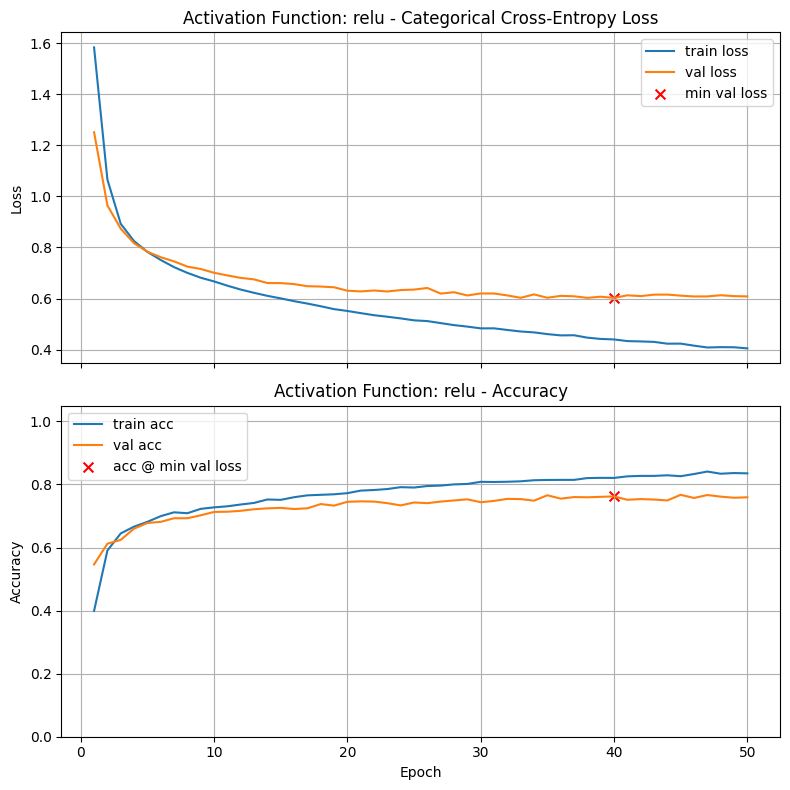

Final Training Loss:            0.4051
Final Training Accuracy:        0.8352
Final Validation Loss:          0.6084
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.6025 (Epoch 40)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.5937
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:07

Activation Function: tanh



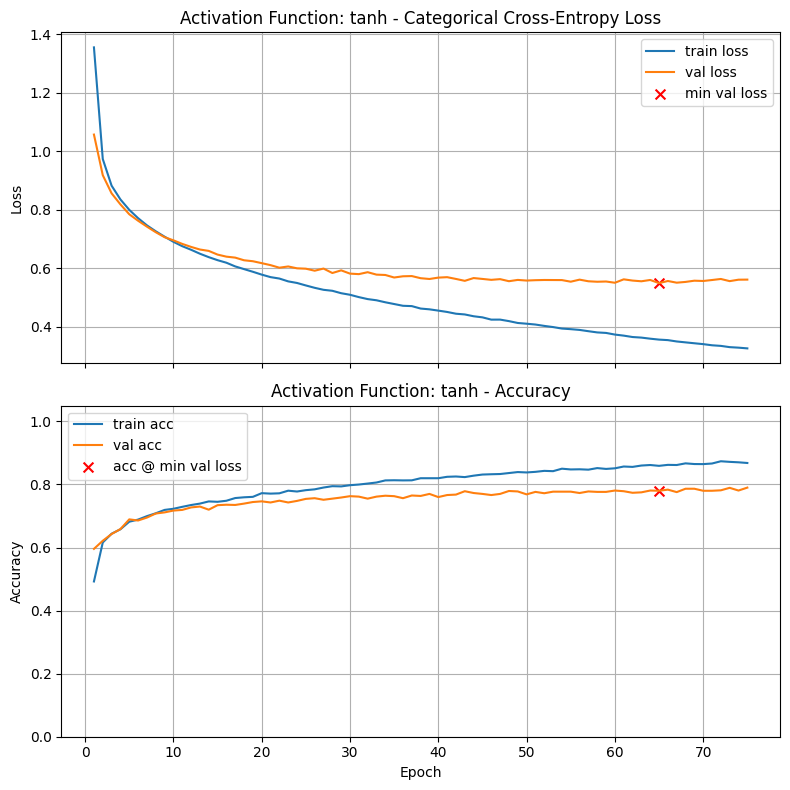

Final Training Loss:            0.3259
Final Training Accuracy:        0.8681
Final Validation Loss:          0.5610
Final Validation Accuracy:      0.7900
Minimum Validation Loss:        0.5490 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7800

Test Loss: 0.5628
Test Accuracy: 0.7736

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:10

Activation Function: sigmoid



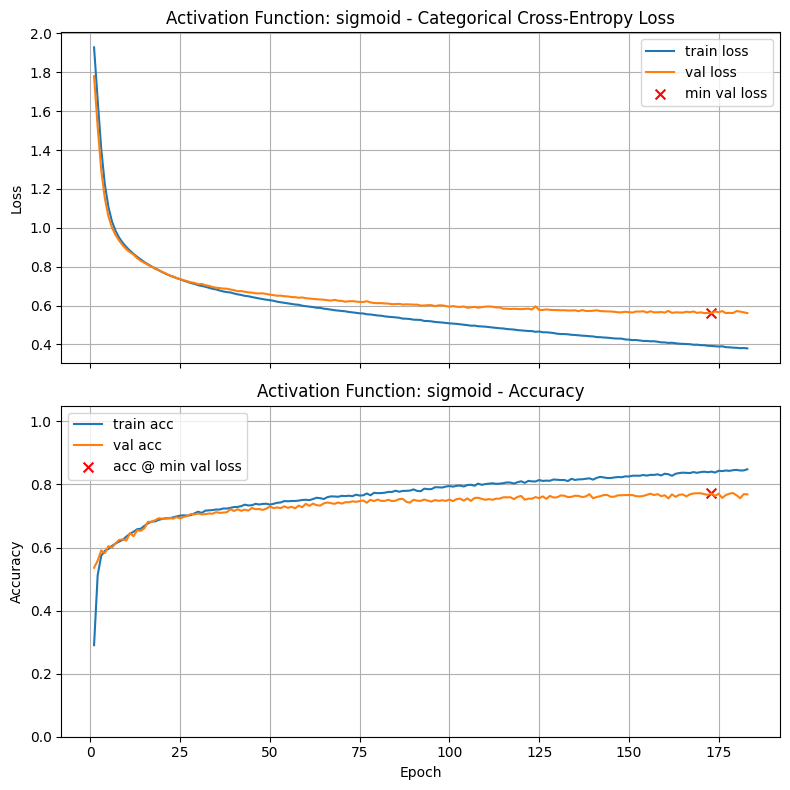

Final Training Loss:            0.3798
Final Training Accuracy:        0.8481
Final Validation Loss:          0.5613
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5605 (Epoch 173)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5677
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:24


In [23]:
# Your code here. Add as many cells as you need.
activation = ['relu', 'tanh', 'sigmoid']

results_1 = pd.DataFrame(columns=['Activation Function', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2])

for i, func in enumerate(activation):
    model = build_model(X_train.shape[1], [ (64, func, 0.0, 0.0), (32, func, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Activation Function: {func}", verbose=0, return_history = True)
    results_1.loc[i] = [func, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [24]:
results_1

,Activation Function,Best Val Accuracy,Min Val Loss
0,relu,0.762143,0.602517
1,tanh,0.78,0.548991
2,sigmoid,0.771429,0.560466


### Graded Questions

In [25]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = results_1['Best Val Accuracy'].idxmax()            # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [26]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 1


In [27]:
# Set a1b to the validation accuracy found by this best activation function

a1b = results_1['Best Val Accuracy'].max()            # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7800


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Learning Rate: 0.001



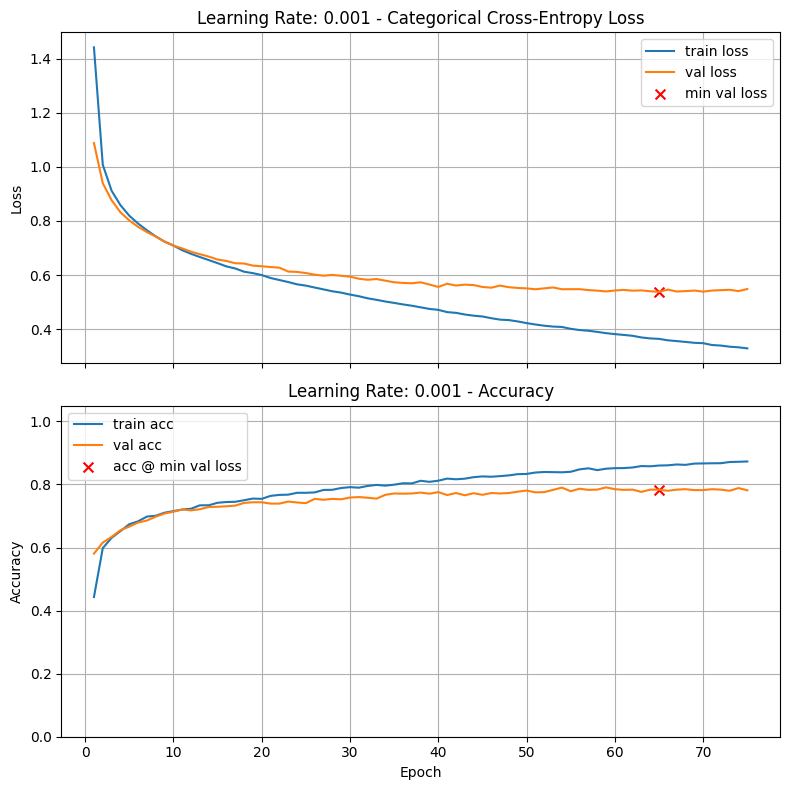

Final Training Loss:            0.3285
Final Training Accuracy:        0.8729
Final Validation Loss:          0.5482
Final Validation Accuracy:      0.7814
Minimum Validation Loss:        0.5376 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7836

Test Loss: 0.5743
Test Accuracy: 0.7714

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:10

Learning Rate: 0.0005



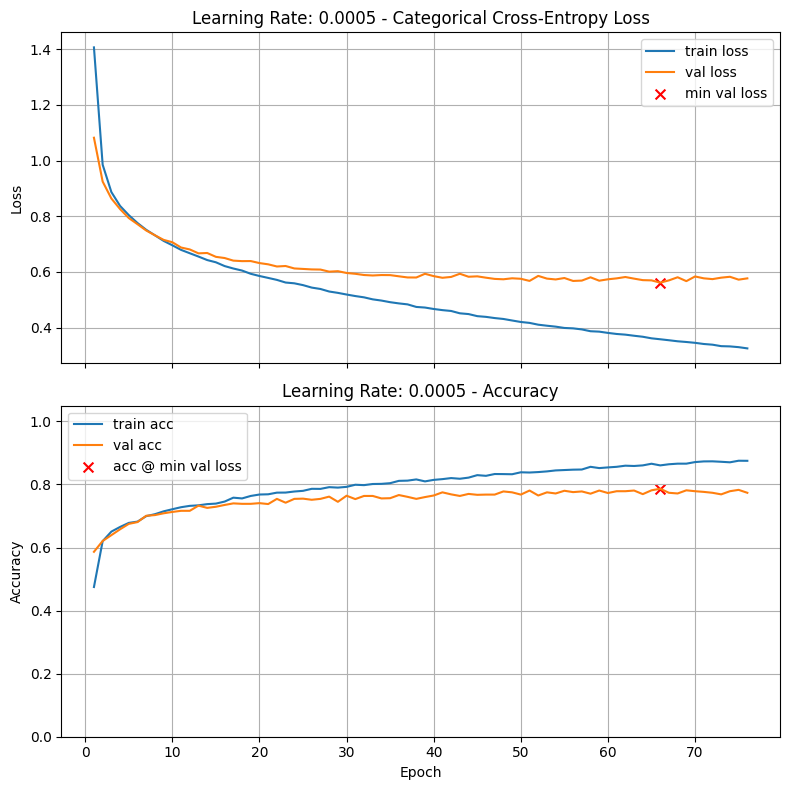

Final Training Loss:            0.3259
Final Training Accuracy:        0.8750
Final Validation Loss:          0.5771
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.5617 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7864

Test Loss: 0.5788
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:10

Learning Rate: 0.0001



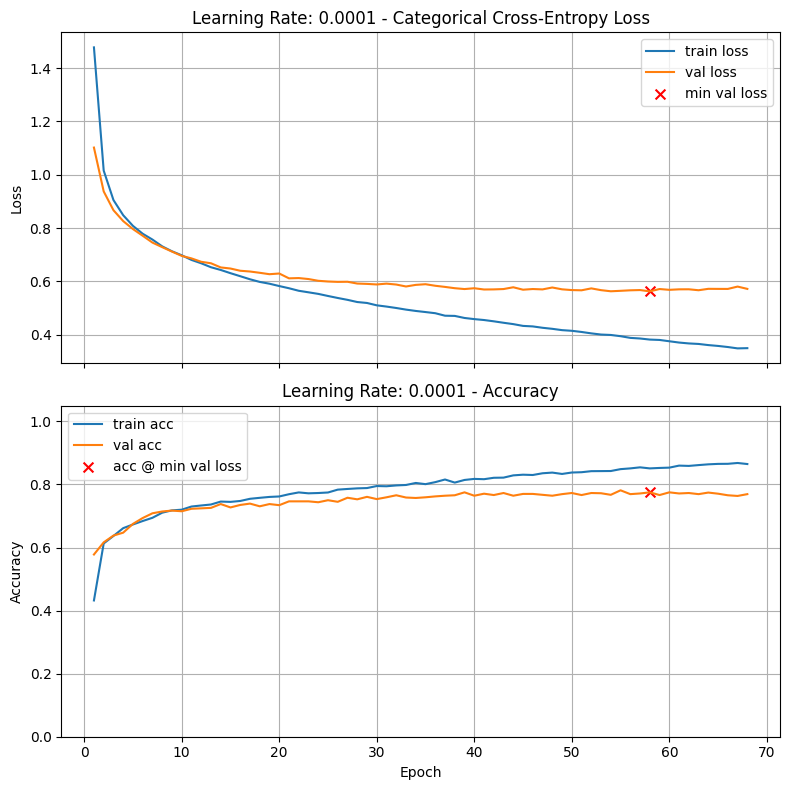

Final Training Loss:            0.3494
Final Training Accuracy:        0.8648
Final Validation Loss:          0.5717
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5624 (Epoch 58)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.5900
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:09

Learning Rate: 5e-05



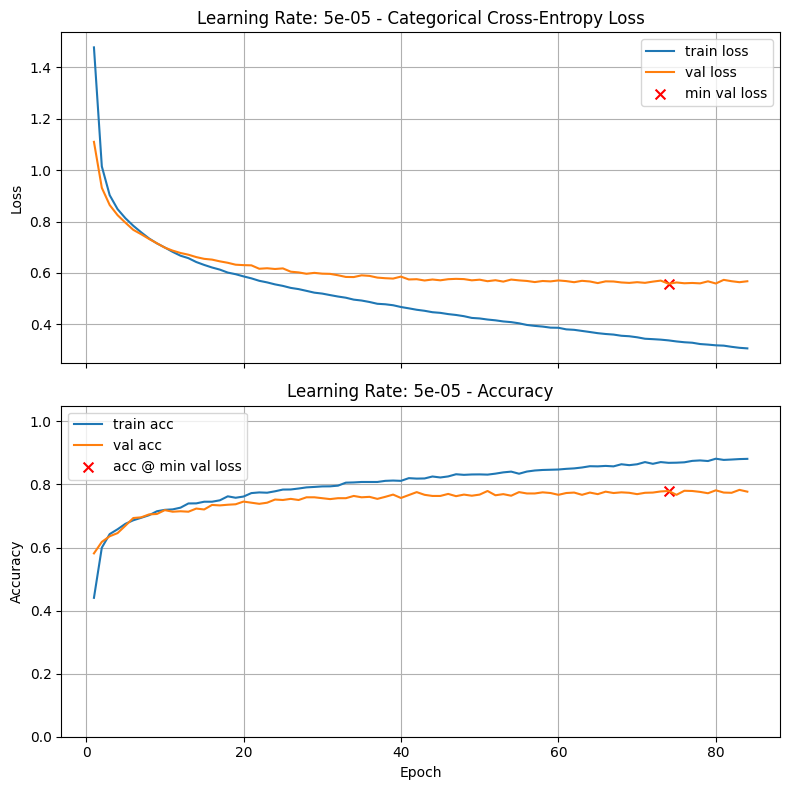

Final Training Loss:            0.3063
Final Training Accuracy:        0.8812
Final Validation Loss:          0.5675
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5576 (Epoch 74)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5611
Test Accuracy: 0.7707

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:11

Learning Rate: 1e-05



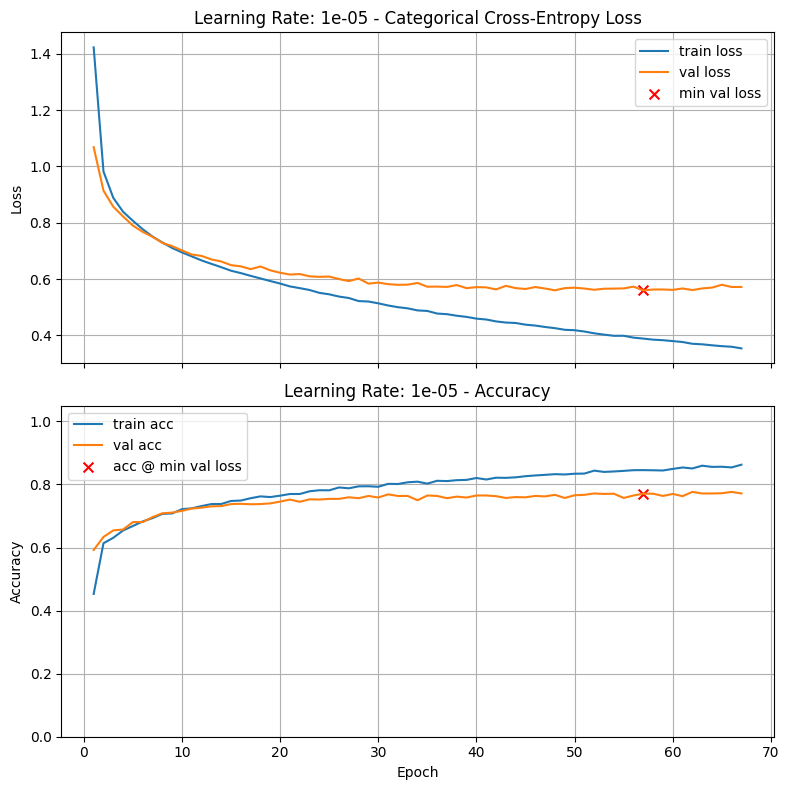

Final Training Loss:            0.3536
Final Training Accuracy:        0.8626
Final Validation Loss:          0.5719
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5597 (Epoch 57)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.5794
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:09


In [29]:
# Your code here. Add as many cells as you need.
learning_rate = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results_2 = pd.DataFrame(columns=['Learning Rate', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4])

for i, lr in enumerate(learning_rate):
    model = build_model(X_train.shape[1], [ (64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Learning Rate: {lr}", verbose=0, return_history = True)
    results_2.loc[i] = [lr, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [32]:
results_2

,Learning Rate,Best Val Accuracy,Min Val Loss
0,0.001,0.783571,0.537648
1,0.0005,0.786429,0.561711
2,0.0001,0.775,0.562391
3,0.00005,0.779286,0.557553
4,0.00001,0.770714,0.559744


#### Graded Questions

In [33]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = results_2['Best Val Accuracy'].idxmax()           # Replace 0.0 with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 1.000000


In [35]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = results_2['Best Val Accuracy'].max()           # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7864


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3



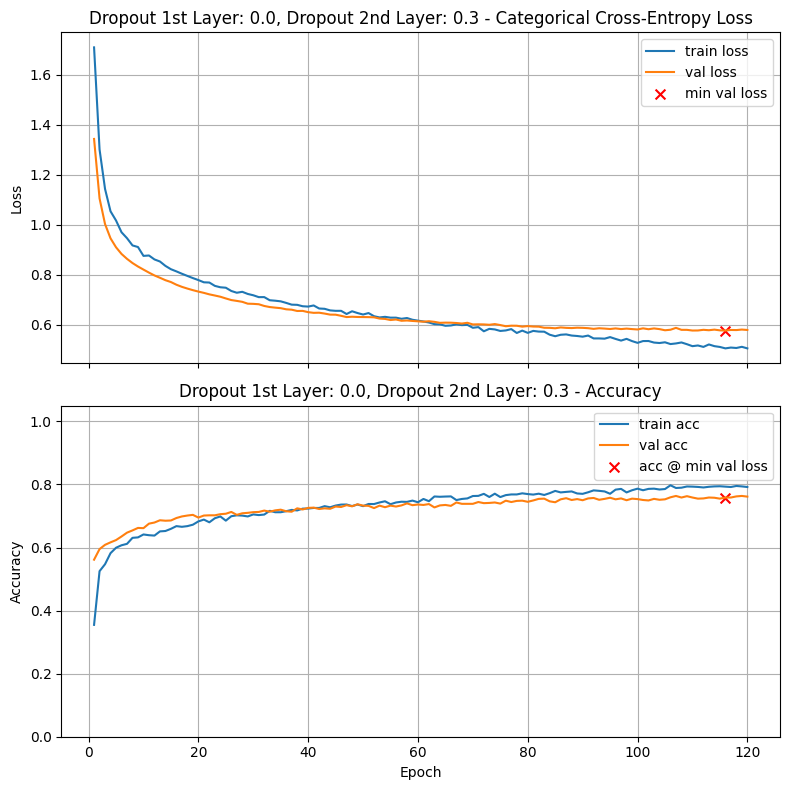

Final Training Loss:            0.5053
Final Training Accuracy:        0.7919
Final Validation Loss:          0.5790
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5767 (Epoch 116)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.6031
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:17

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4



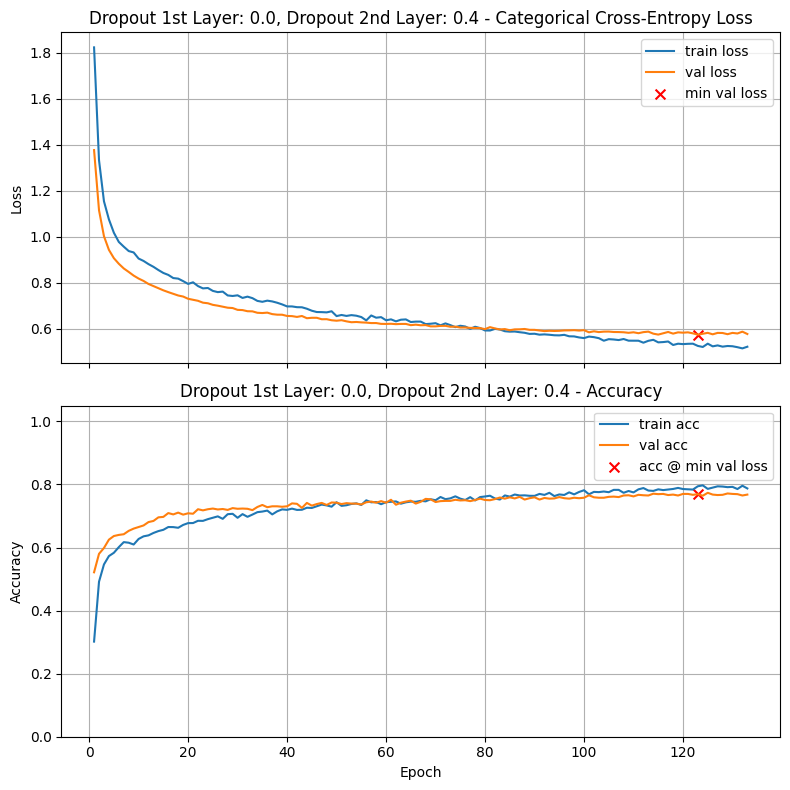

Final Training Loss:            0.5214
Final Training Accuracy:        0.7874
Final Validation Loss:          0.5768
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5738 (Epoch 123)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5970
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:18

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5



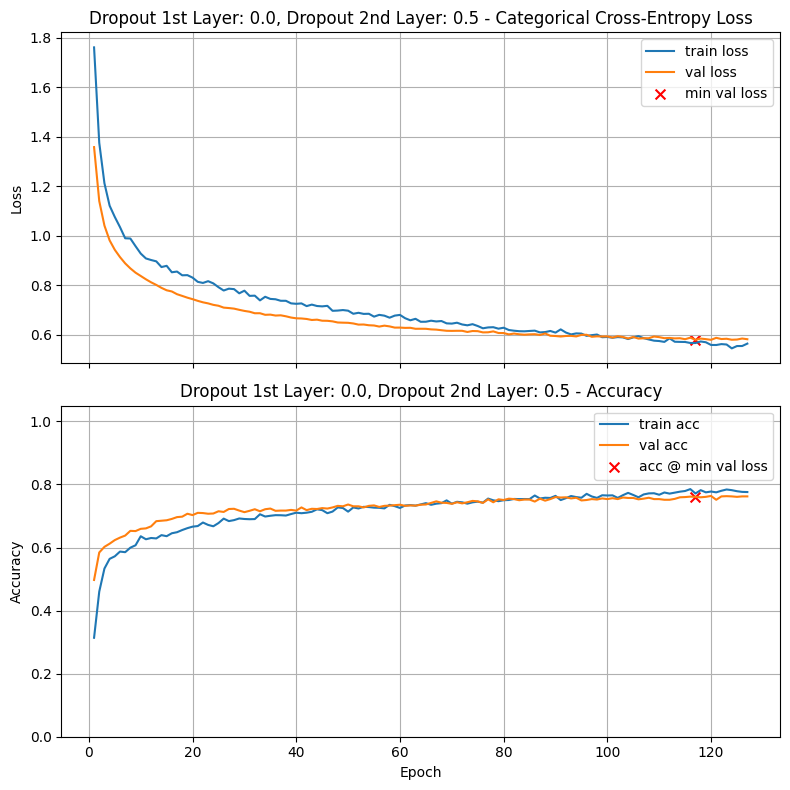

Final Training Loss:            0.5650
Final Training Accuracy:        0.7760
Final Validation Loss:          0.5827
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5803 (Epoch 117)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6171
Test Accuracy: 0.7464

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:17

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3



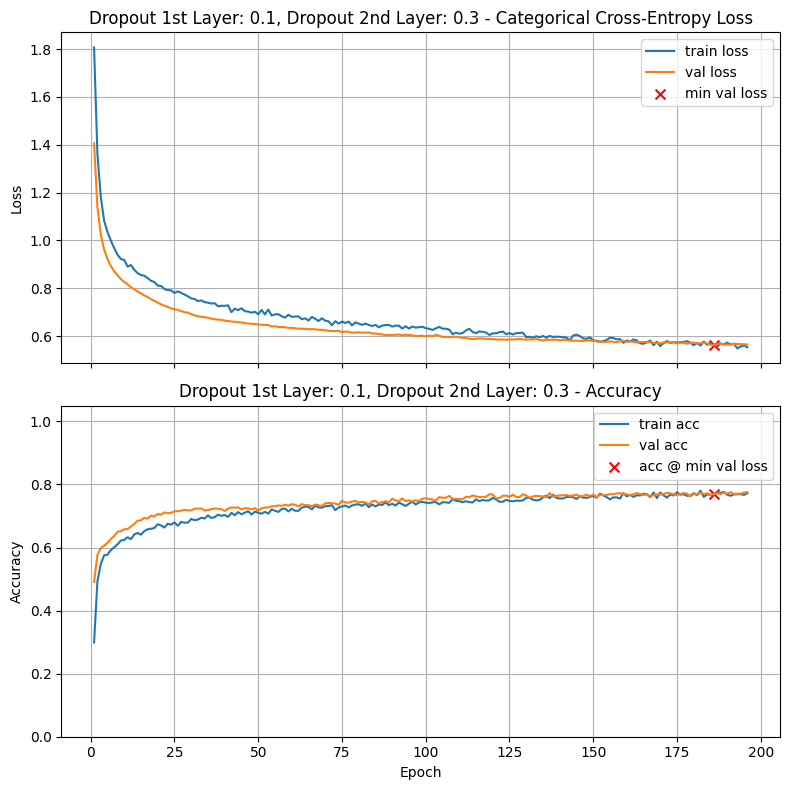

Final Training Loss:            0.5531
Final Training Accuracy:        0.7721
Final Validation Loss:          0.5645
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5613 (Epoch 186)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5970
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:28

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4



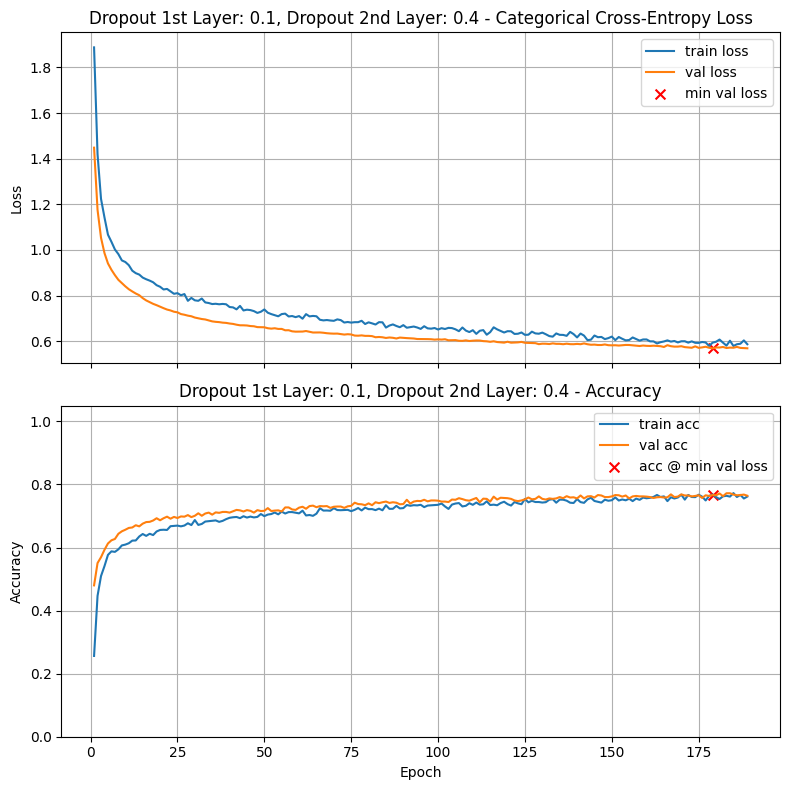

Final Training Loss:            0.5868
Final Training Accuracy:        0.7617
Final Validation Loss:          0.5690
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5686 (Epoch 179)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6007
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:27

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5



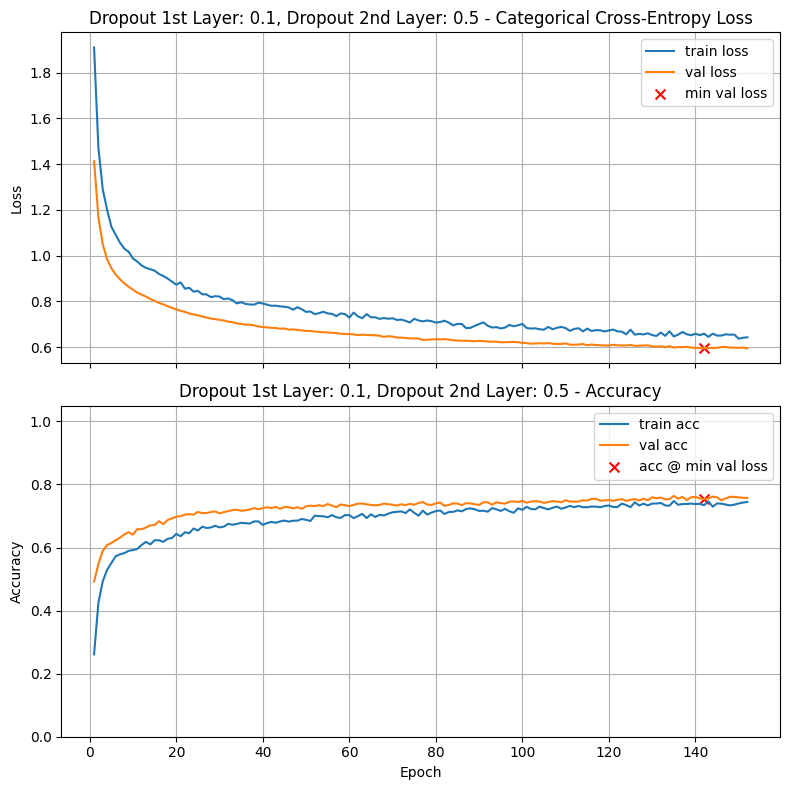

Final Training Loss:            0.6425
Final Training Accuracy:        0.7445
Final Validation Loss:          0.5941
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.5941 (Epoch 142)
Validation Accuracy @ Min Loss: 0.7536

Test Loss: 0.6253
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:20

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3



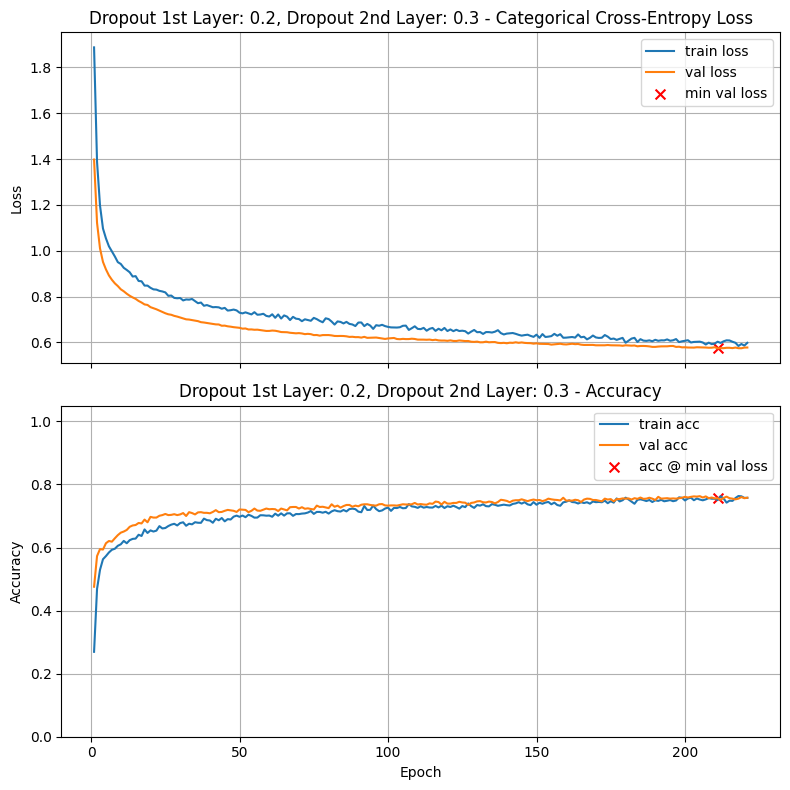

Final Training Loss:            0.5978
Final Training Accuracy:        0.7576
Final Validation Loss:          0.5773
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.5735 (Epoch 211)
Validation Accuracy @ Min Loss: 0.7564

Test Loss: 0.6029
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:29

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4



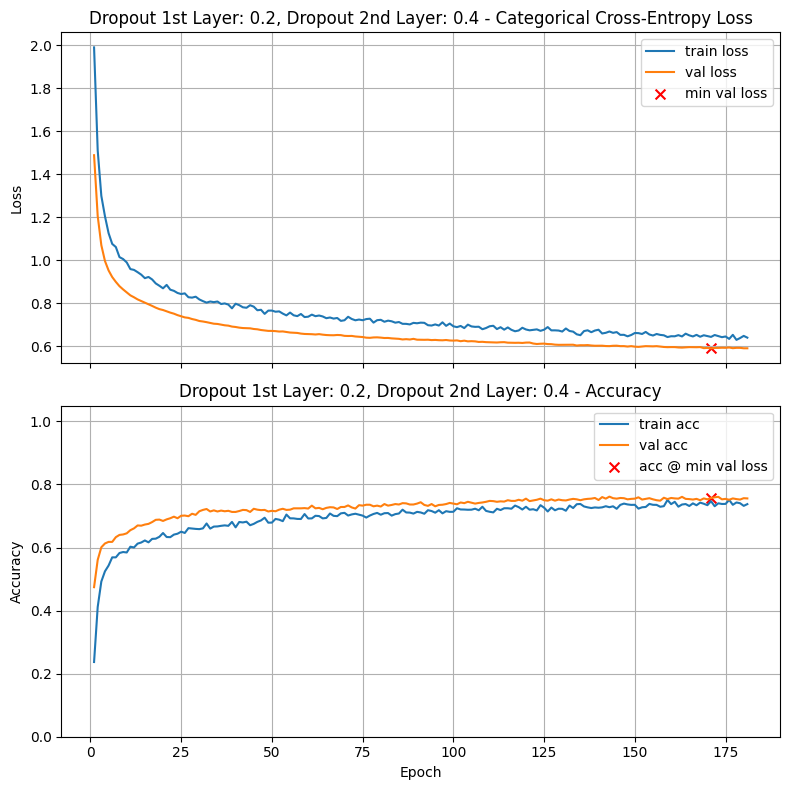

Final Training Loss:            0.6399
Final Training Accuracy:        0.7376
Final Validation Loss:          0.5904
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.5900 (Epoch 171)
Validation Accuracy @ Min Loss: 0.7571

Test Loss: 0.6222
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:25

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5



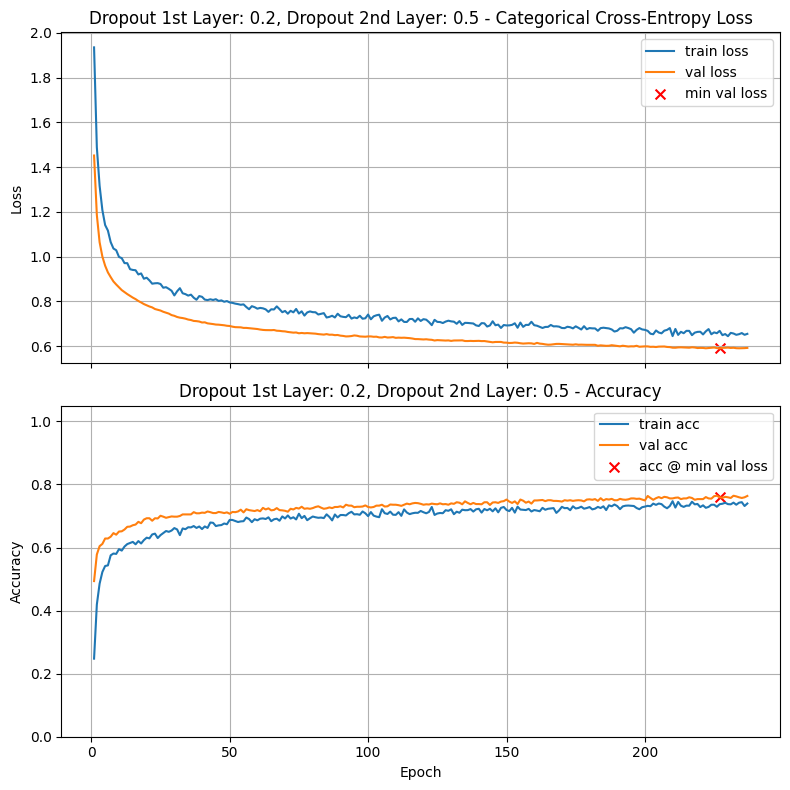

Final Training Loss:            0.6554
Final Training Accuracy:        0.7395
Final Validation Loss:          0.5926
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5905 (Epoch 227)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.6278
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:32


In [46]:
# Your code here. Add as many cells as you need.
lr_3 = 5e-4
af_3 = 'tanh'

drop_out_1st_layer = [0.0, 0.1, 0.2]
drop_out_2nd_layer = [0.3, 0.4, 0.5]

results_3 = pd.DataFrame(columns=['First Dropout', 'Second Dropout', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, drop_out_1st in enumerate(drop_out_1st_layer):
    for j, drop_out_2nd in enumerate(drop_out_2nd_layer):
        model = build_model(X_train.shape[1], [ (64, af_3, 0.0, drop_out_1st), (32, af_3, 0.0, drop_out_2nd)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr_3, title=f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}", verbose=0, return_history = True)
        results_3.iloc[i * 3 + j] = [drop_out_1st, drop_out_2nd, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [47]:
results_3

,First Dropout,Second Dropout,Best Val Accuracy,Min Val Loss
0,0.0,0.3,0.758571,0.576737
1,0.0,0.4,0.769286,0.573842
2,0.0,0.5,0.760714,0.580252
3,0.1,0.3,0.77,0.561297
4,0.1,0.4,0.766429,0.568601
5,0.1,0.5,0.753571,0.594097
6,0.2,0.3,0.756429,0.573508
7,0.2,0.4,0.757143,0.589959
8,0.2,0.5,0.759286,0.590474


In [48]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (results_3['First Dropout'].loc[results_3['Best Val Accuracy'].idxmax()], results_3['Second Dropout'].loc[results_3['Best Val Accuracy'].idxmax()])             # Replace (0.0,0.0) with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.1, 0.3)


In [50]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = results_3['Best Val Accuracy'].max()             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7700


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Regularization: 0.0001, 0.0001



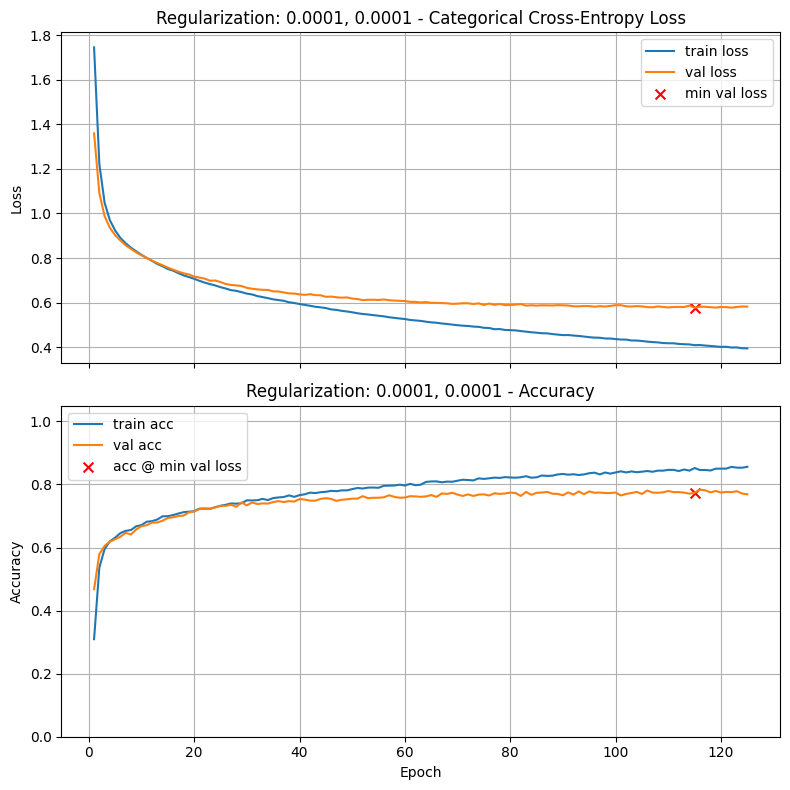

Final Training Loss:            0.3947
Final Training Accuracy:        0.8560
Final Validation Loss:          0.5819
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5770 (Epoch 115)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5896
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:17

Regularization: 0.0001, 0.001



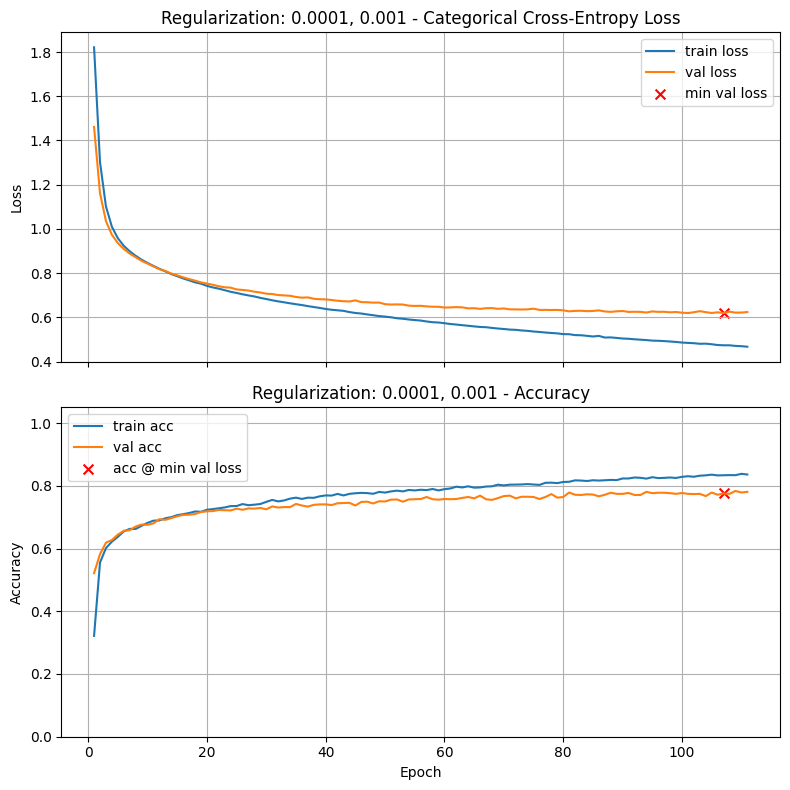

Final Training Loss:            0.4670
Final Training Accuracy:        0.8360
Final Validation Loss:          0.6238
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.6193 (Epoch 107)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6287
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:15

Regularization: 0.0001, 0.01



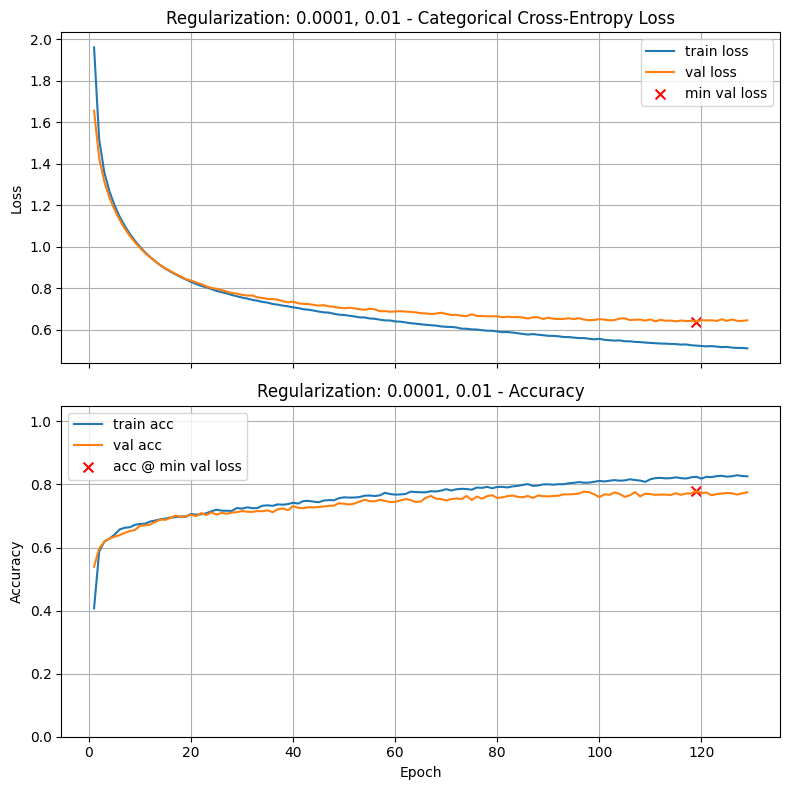

Final Training Loss:            0.5100
Final Training Accuracy:        0.8260
Final Validation Loss:          0.6455
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6389 (Epoch 119)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6609
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.035000

Execution Time: 00:00:17

Regularization: 0.001, 0.0001



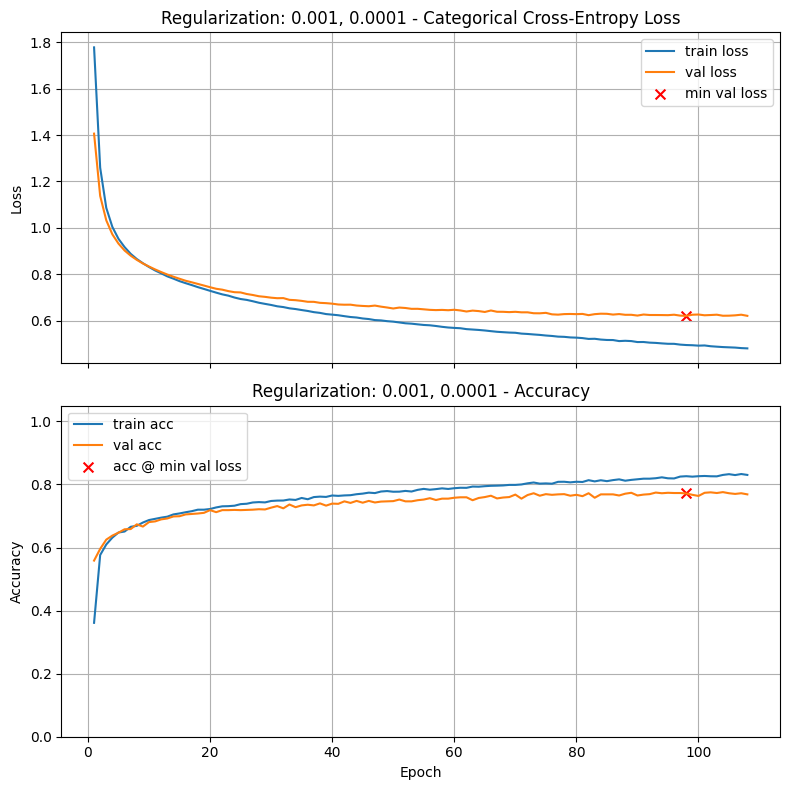

Final Training Loss:            0.4813
Final Training Accuracy:        0.8302
Final Validation Loss:          0.6215
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6212 (Epoch 98)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6383
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.027143

Execution Time: 00:00:14

Regularization: 0.001, 0.001



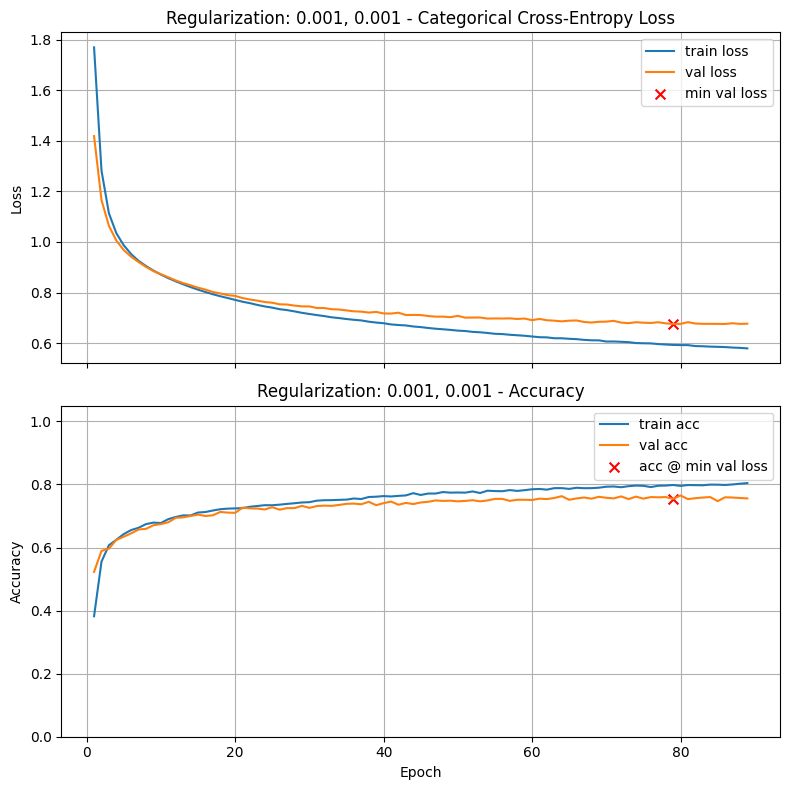

Final Training Loss:            0.5791
Final Training Accuracy:        0.8043
Final Validation Loss:          0.6767
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6755 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6988
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:12

Regularization: 0.001, 0.01



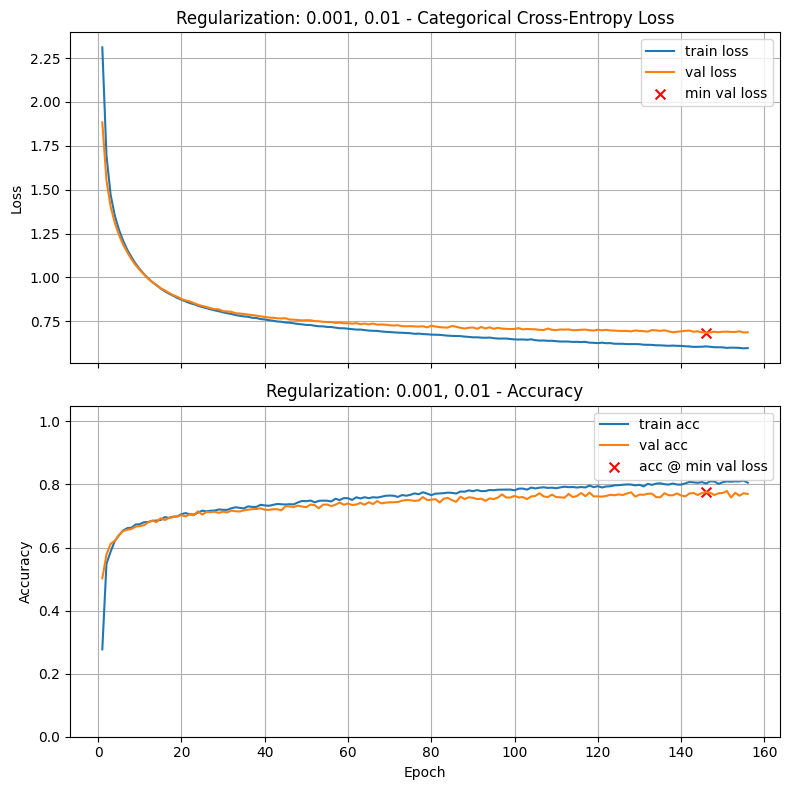

Final Training Loss:            0.5974
Final Training Accuracy:        0.8057
Final Validation Loss:          0.6872
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6847 (Epoch 146)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.7041
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:21

Regularization: 0.01, 0.0001



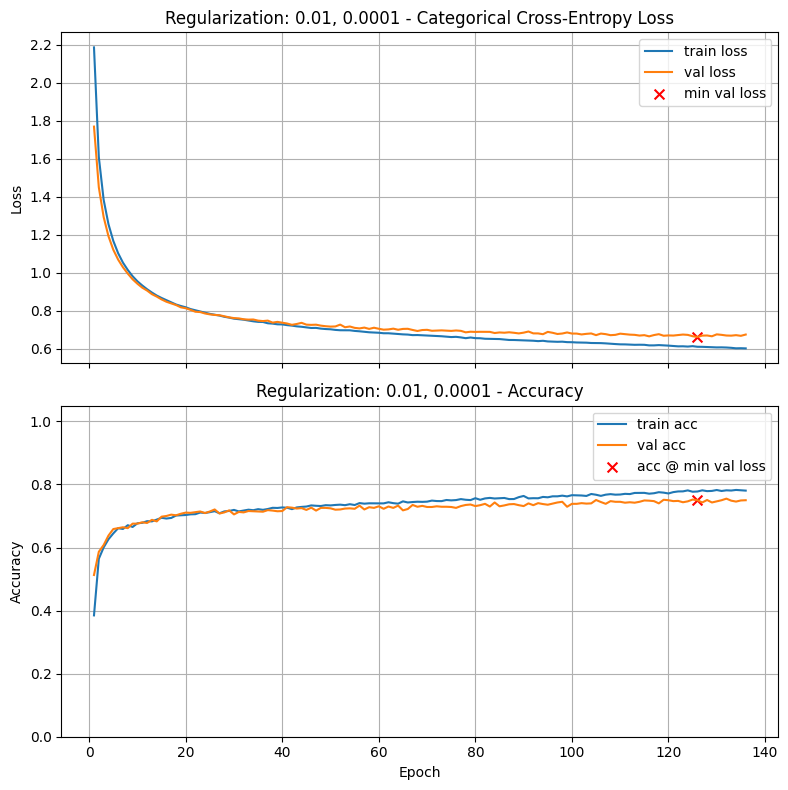

Final Training Loss:            0.6031
Final Training Accuracy:        0.7805
Final Validation Loss:          0.6759
Final Validation Accuracy:      0.7500
Minimum Validation Loss:        0.6633 (Epoch 126)
Validation Accuracy @ Min Loss: 0.7500

Test Loss: 0.6742
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:19

Regularization: 0.01, 0.001



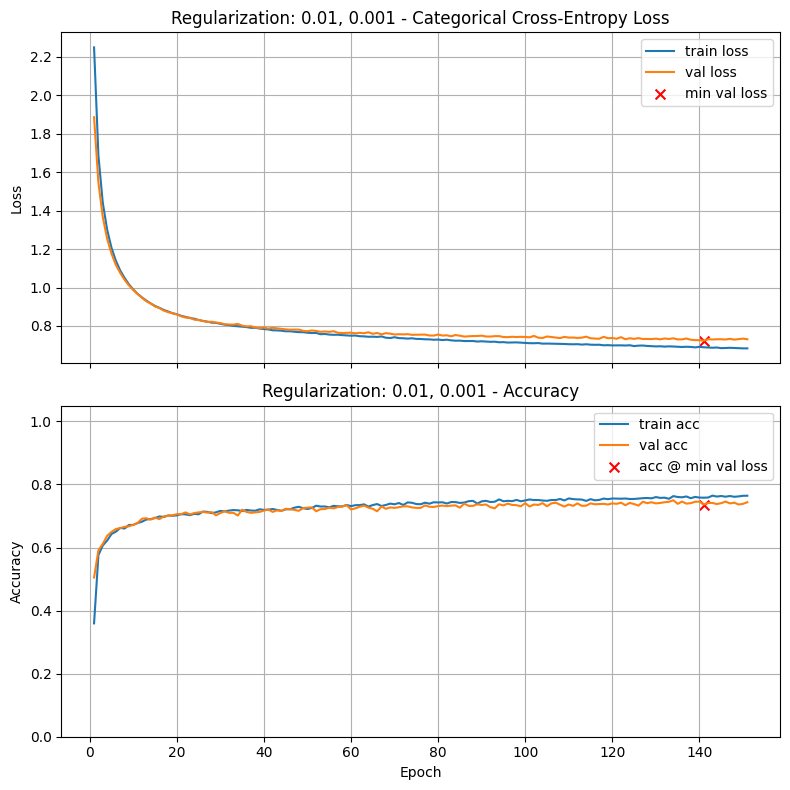

Final Training Loss:            0.6834
Final Training Accuracy:        0.7643
Final Validation Loss:          0.7307
Final Validation Accuracy:      0.7436
Minimum Validation Loss:        0.7239 (Epoch 141)
Validation Accuracy @ Min Loss: 0.7364

Test Loss: 0.7480
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:21

Regularization: 0.01, 0.01



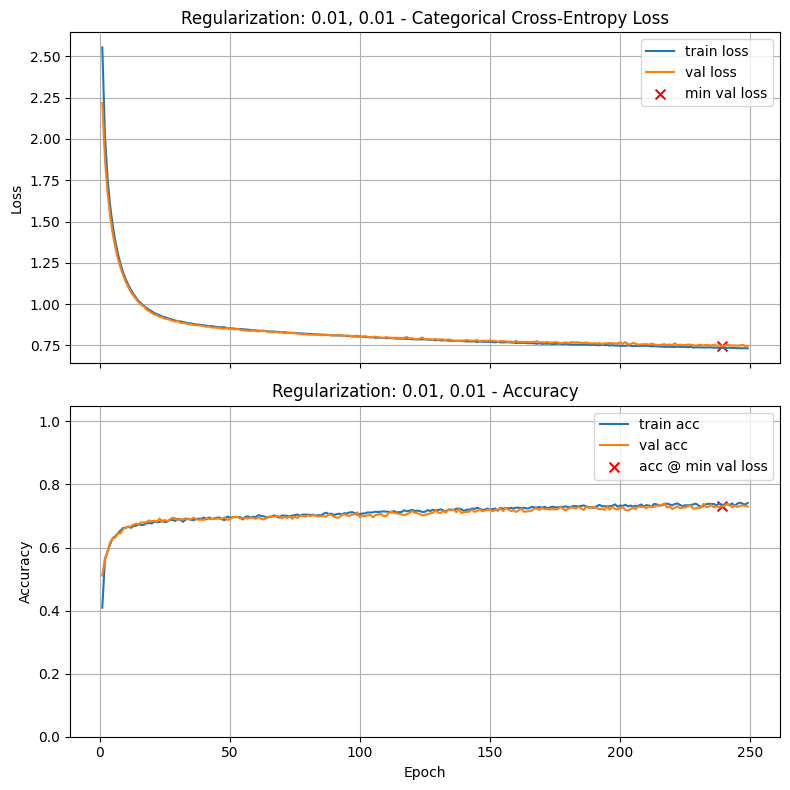

Final Training Loss:            0.7325
Final Training Accuracy:        0.7414
Final Validation Loss:          0.7477
Final Validation Accuracy:      0.7300
Minimum Validation Loss:        0.7474 (Epoch 239)
Validation Accuracy @ Min Loss: 0.7307

Test Loss: 0.7813
Test Accuracy: 0.7229

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:32


In [52]:
# Your code here. Add as many cells as you need. 
lr_4 = 5e-4
af_4 = 'tanh'

regularization_4 = [1e-4, 1e-3, 1e-2]

results_4 = pd.DataFrame(columns=['First Layer Reg', 'Second Layer Reg', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, reg_i in enumerate(regularization_4):
    for j, reg_j in enumerate(regularization_4):
        model = build_model(X_train.shape[1], [ (64, af_4, reg_i, 0.0), (32, af_4, reg_j, 0.0)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr_4, title=f"Regularization: {reg_i}, {reg_j}", verbose=0, return_history = True)
        results_4.iloc[i * 3 + j] = [reg_i, reg_j, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [53]:
results_4

,First Layer Reg,Second Layer Reg,Best Val Accuracy,Min Val Loss
0,0.0001,0.0001,0.773571,0.57702
1,0.0001,0.001,0.775714,0.619305
2,0.0001,0.01,0.778571,0.638927
3,0.001,0.0001,0.771429,0.621189
4,0.001,0.001,0.754286,0.675478
5,0.001,0.01,0.775714,0.68468
6,0.01,0.0001,0.75,0.663349
7,0.01,0.001,0.736429,0.723936
8,0.01,0.01,0.730714,0.747374


In [54]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (results_4['First Layer Reg'].iloc[results_4['Best Val Accuracy'].idxmax()], results_4['Second Layer Reg'].iloc[results_4['Best Val Accuracy'].idxmax()])             # Replace (0.0,0.0) with your answer

In [55]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.01)


In [56]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = results_4['Best Val Accuracy'].max()             # Replace 0.0 with your answer

In [57]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7786


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Regularization: 0.0001, 0.0001



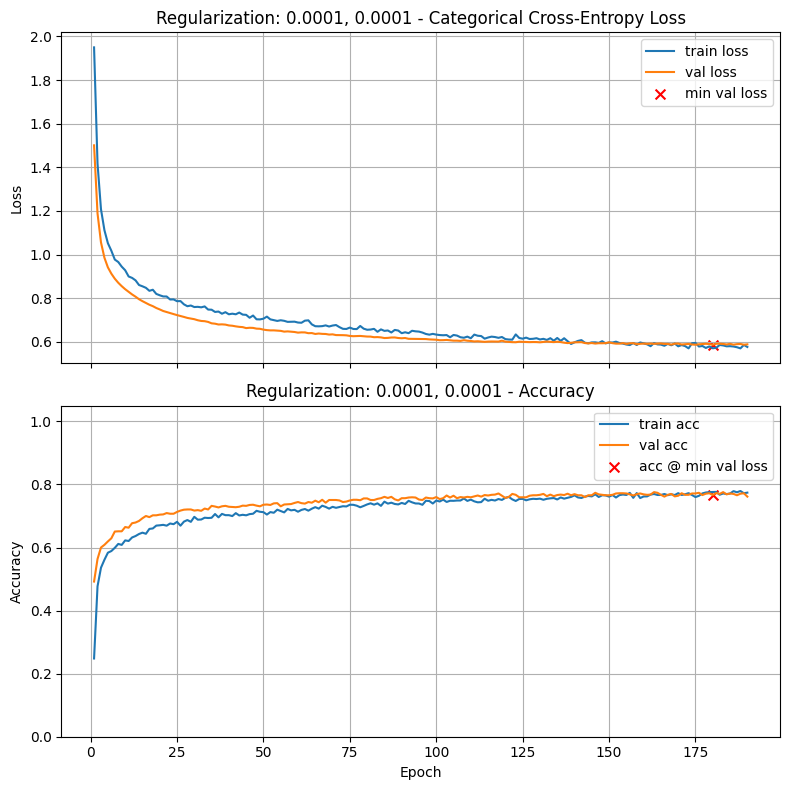

Final Training Loss:            0.5772
Final Training Accuracy:        0.7740
Final Validation Loss:          0.5892
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5871 (Epoch 180)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6093
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:26

Regularization: 0.0001, 0.001



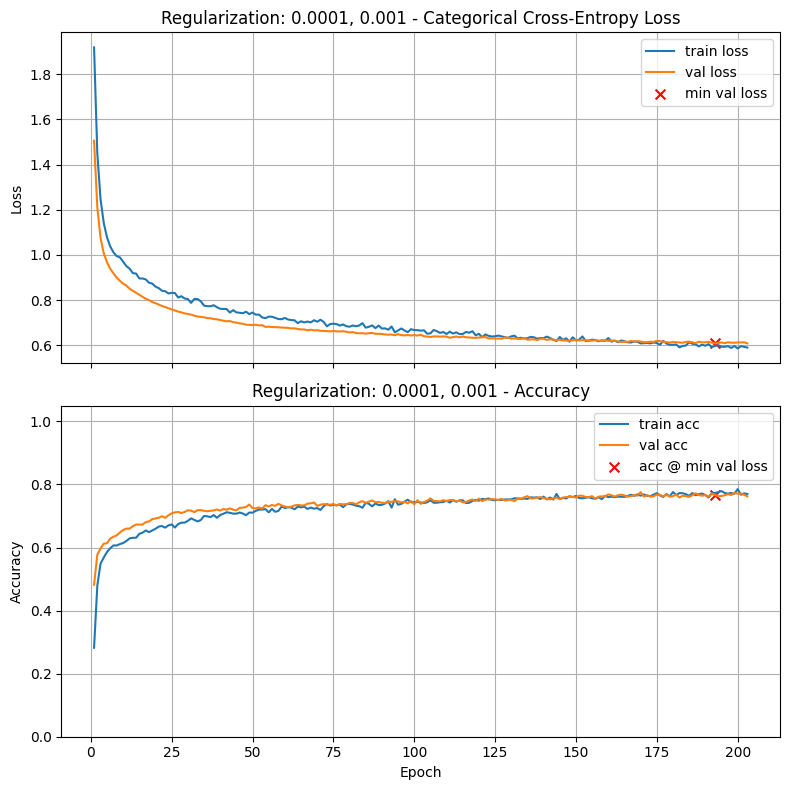

Final Training Loss:            0.5898
Final Training Accuracy:        0.7698
Final Validation Loss:          0.6087
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.6083 (Epoch 193)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6384
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:27

Regularization: 0.0001, 0.01



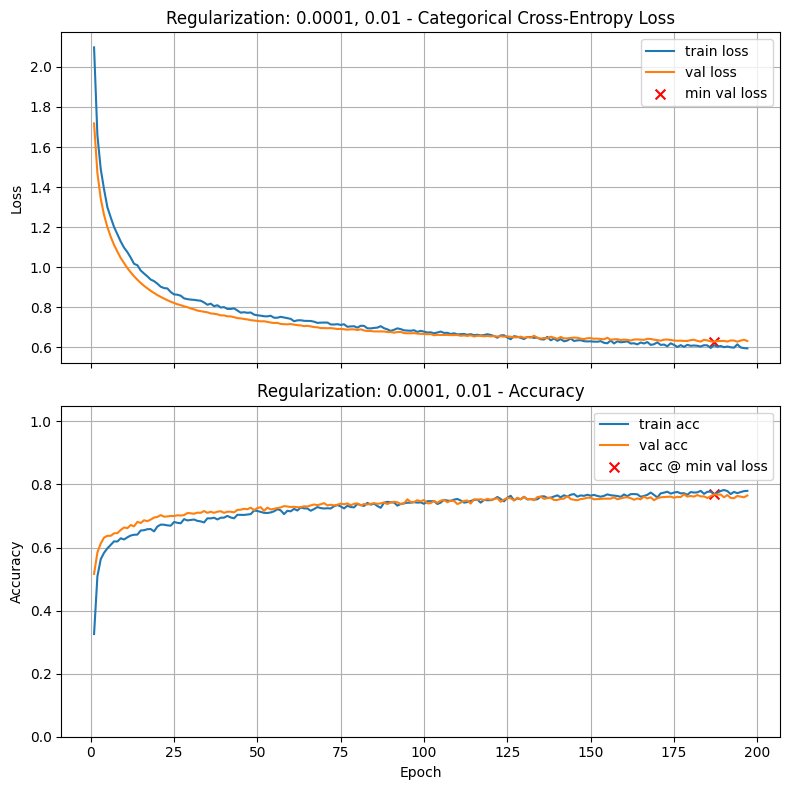

Final Training Loss:            0.5951
Final Training Accuracy:        0.7798
Final Validation Loss:          0.6319
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.6283 (Epoch 187)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6550
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:26

Regularization: 0.001, 0.0001



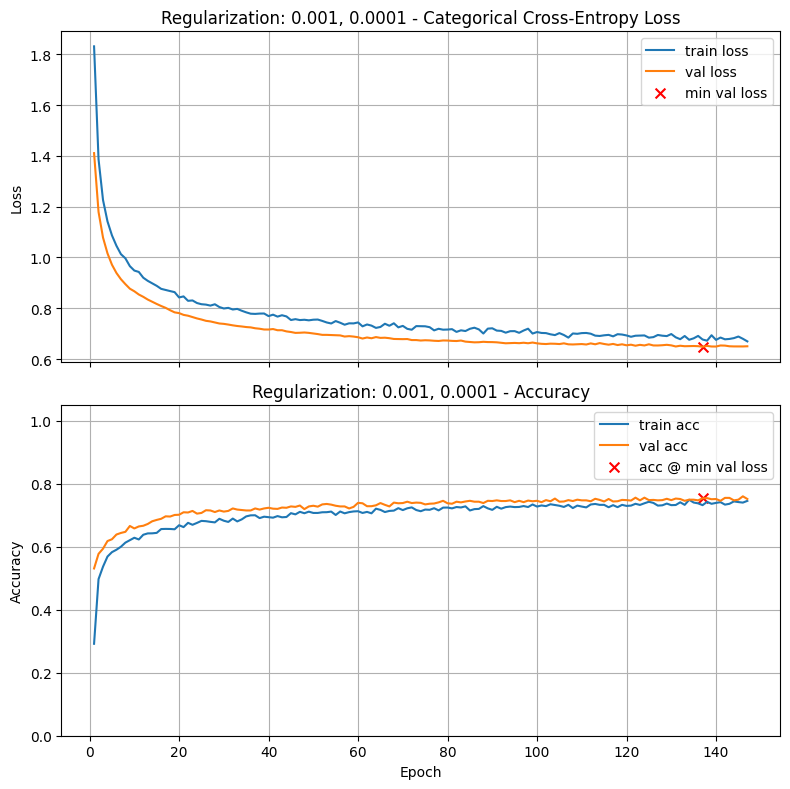

Final Training Loss:            0.6694
Final Training Accuracy:        0.7462
Final Validation Loss:          0.6501
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.6482 (Epoch 137)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6743
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:20

Regularization: 0.001, 0.001



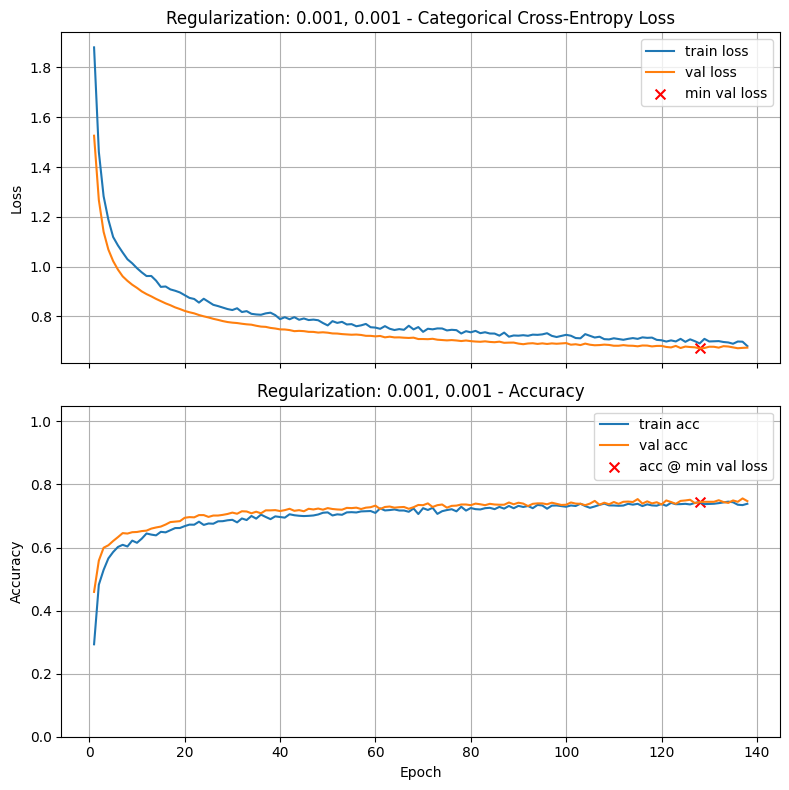

Final Training Loss:            0.6812
Final Training Accuracy:        0.7388
Final Validation Loss:          0.6749
Final Validation Accuracy:      0.7471
Minimum Validation Loss:        0.6719 (Epoch 128)
Validation Accuracy @ Min Loss: 0.7443

Test Loss: 0.6952
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:19

Regularization: 0.001, 0.01



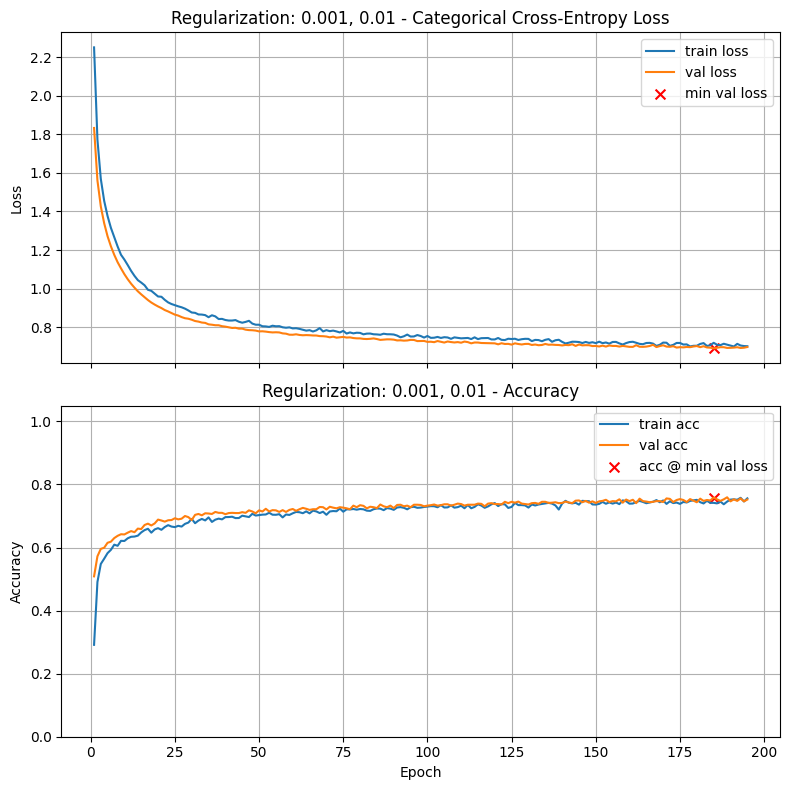

Final Training Loss:            0.7020
Final Training Accuracy:        0.7560
Final Validation Loss:          0.6980
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.6909 (Epoch 185)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.7193
Test Accuracy: 0.7400

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:26

Regularization: 0.01, 0.0001



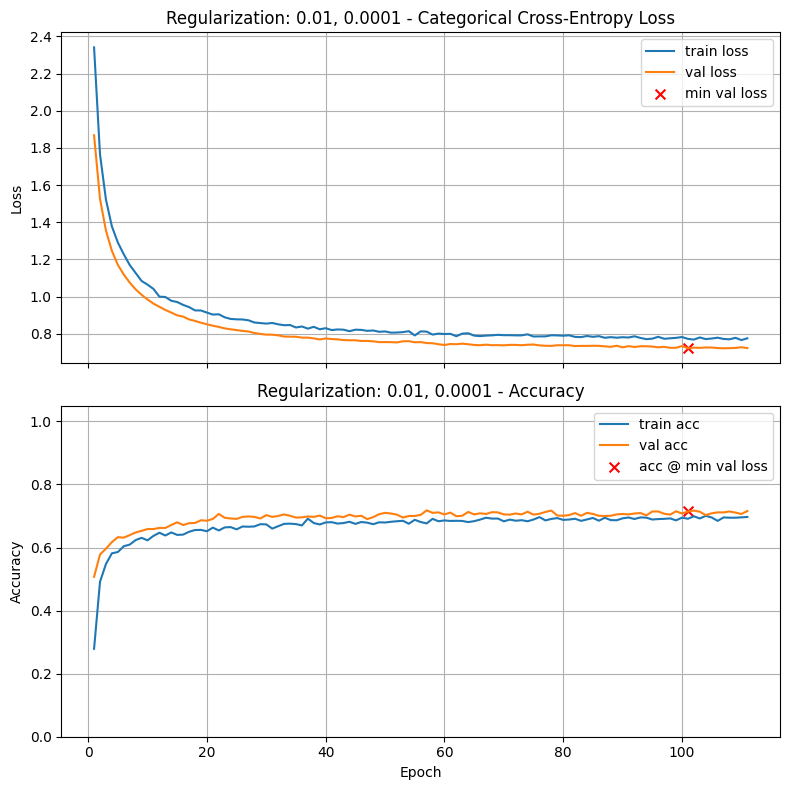

Final Training Loss:            0.7759
Final Training Accuracy:        0.6969
Final Validation Loss:          0.7236
Final Validation Accuracy:      0.7157
Minimum Validation Loss:        0.7218 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7143

Test Loss: 0.7485
Test Accuracy: 0.7007

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:15

Regularization: 0.01, 0.001



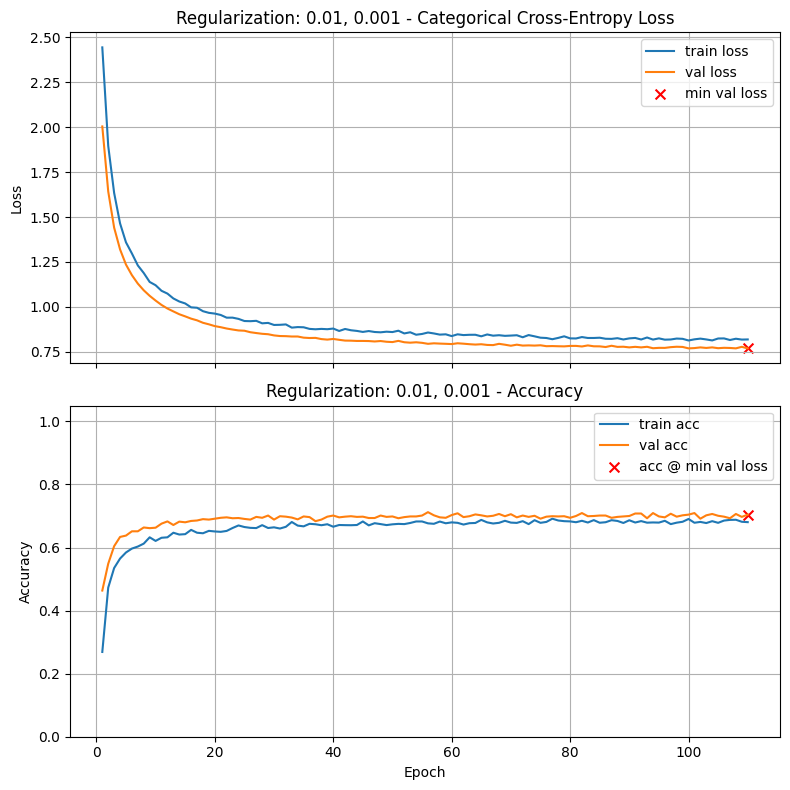

Final Training Loss:            0.8181
Final Training Accuracy:        0.6805
Final Validation Loss:          0.7684
Final Validation Accuracy:      0.7043
Minimum Validation Loss:        0.7684 (Epoch 110)
Validation Accuracy @ Min Loss: 0.7043

Test Loss: 0.7973
Test Accuracy: 0.6929

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:16

Regularization: 0.01, 0.01



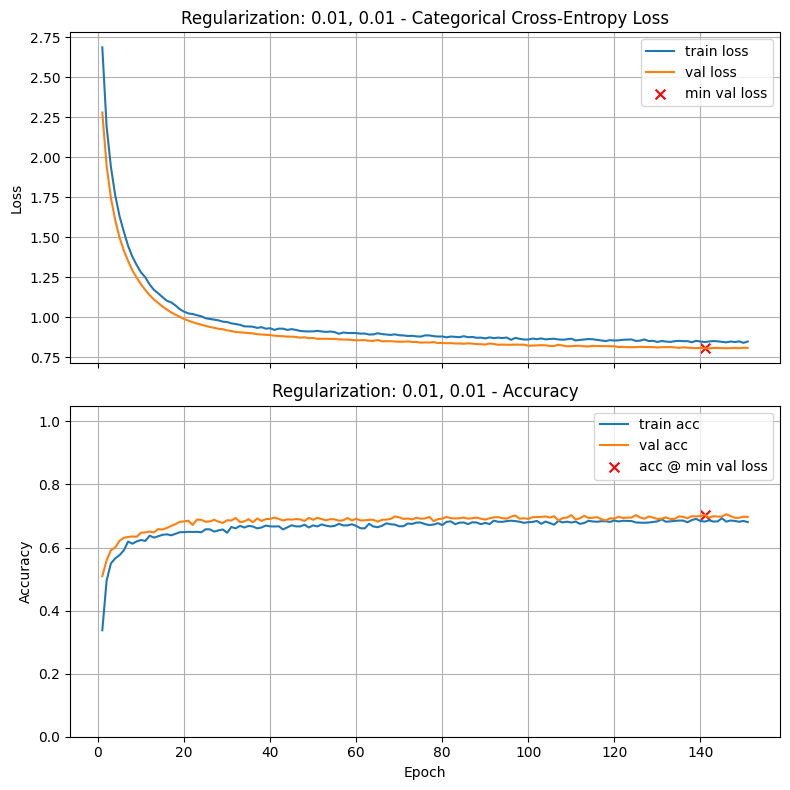

Final Training Loss:            0.8478
Final Training Accuracy:        0.6807
Final Validation Loss:          0.8086
Final Validation Accuracy:      0.6971
Minimum Validation Loss:        0.8049 (Epoch 141)
Validation Accuracy @ Min Loss: 0.7036

Test Loss: 0.8259
Test Accuracy: 0.7014

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:21


In [61]:
# Your code here. Add as many cells as you need.
lr_5 = 5e-4
af_5 = 'tanh'

regularization_5 = [1e-4, 1e-3, 1e-2]

drop_out_1st_layer_5 = 0.1
drop_out_2nd_layer_5 = 0.3

results_5 = pd.DataFrame(columns=['First Layer Reg', 'Second Layer Reg', 'First Dropout', 'Second Dropout', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, reg_i in enumerate(regularization_5):
    for j, reg_j in enumerate(regularization_5):
        model = build_model(X_train.shape[1], [ (64, af_5, reg_i, drop_out_1st_layer_5), (32, af_5, reg_j, drop_out_2nd_layer_5)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr_5, title=f"Regularization: {reg_i}, {reg_j}", verbose=0, return_history = True)
        results_5.iloc[i * 3 + j] = [reg_i, reg_j, drop_out_1st_layer_5, drop_out_2nd_layer_5, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [62]:
results_5

,First Layer Reg,Second Layer Reg,First Dropout,Second Dropout,Best Val Accuracy,Min Val Loss
0,0.0001,0.0001,0.1,0.3,0.766429,0.587056
1,0.0001,0.001,0.1,0.3,0.766429,0.608292
2,0.0001,0.01,0.1,0.3,0.768571,0.628288
3,0.001,0.0001,0.1,0.3,0.754286,0.648167
4,0.001,0.001,0.1,0.3,0.744286,0.671855
5,0.001,0.01,0.1,0.3,0.758571,0.690865
6,0.01,0.0001,0.1,0.3,0.714286,0.721813
7,0.01,0.001,0.1,0.3,0.704286,0.768354
8,0.01,0.01,0.1,0.3,0.703571,0.804906


In [ ]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.0000


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [ ]:
# Your code here


In [ ]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.0000


### Optional: Print out your results of all experiments

In [ ]:
print_results()

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?